In [3]:
# Own Libraries
from utils.data import load_data
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms
# 3rd Party Libraries
from skimage.io import imread
from skimage.morphology import closing, opening
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.exposure import rescale_intensity
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
# Load Data
db, db_files = load_data("./data/BBDD/",".jpg", desc = "Loading BBDD Data...")
qsd2_w1, qsd2_w1_files = load_data("./data/qsd2_w1/",".jpg", desc = "Loading qsd2_w1 Data...")
qsd1_w2, qsd1_w2_files = load_data("./data/qsd2_w1/",".jpg", desc = "Loading qsd1_w2 Data...")
qsd2_w2, qsd2_w2_files = load_data("./data/qsd2_w2/",".jpg", desc = "Loading qsd2_w2 Data...")

# 3D Normalized Histograms Multiresolutio/Block Images
#db_feature_matrix = calculate_histograms(db,16,n_rows=4,n_cols=4,desc="Normalized 3D Histograms Calculation for BBDD...")
#qsd2_w1_feature_matrix = calculate_histograms(qsd2_w1,16,n_rows=4,n_cols=4,desc = "Normalized 3D Histograms Calculation for qsd2_w1...")

Loading qsd2_w1 Data...:   0%|          | 0/30 [00:00<?, ?it/s]

./data/BBDD/ read: 287 images


Loading qsd1_w2 Data...:   0%|          | 0/30 [00:00<?, ?it/s]

./data/qsd2_w1/ read: 30 images


Loading qsd2_w2 Data...:  40%|████      | 12/30 [00:00<00:00, 62.43it/s]

./data/qsd2_w1/ read: 30 images


Loading qsd2_w2 Data...: 100%|██████████| 30/30 [00:00<00:00, 51.30it/s]


./data/qsd2_w2/ read: 30 images


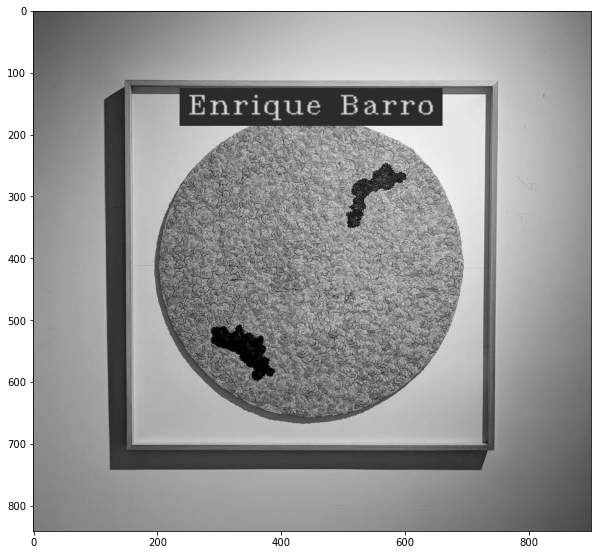

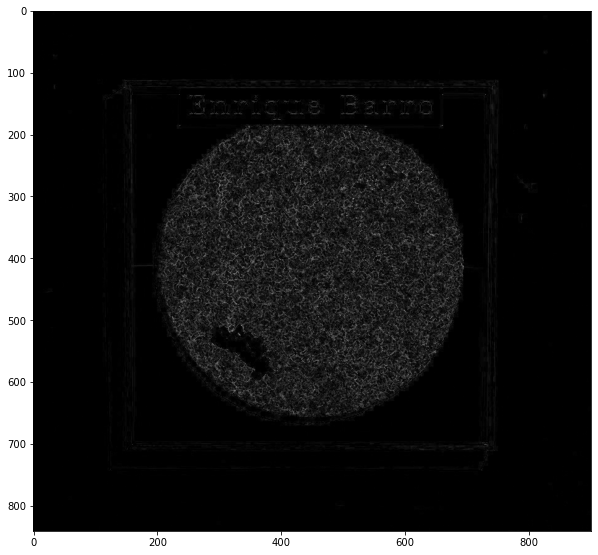

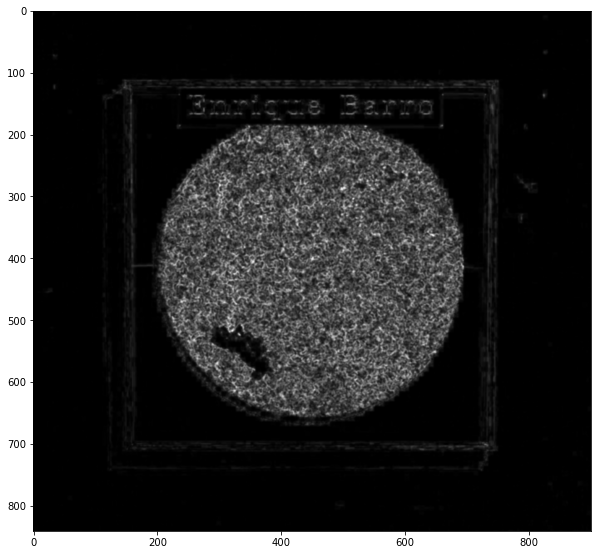

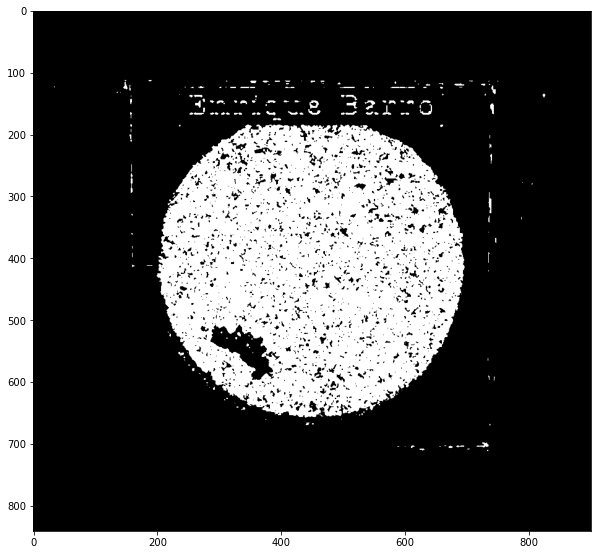

In [5]:
im = rgb2gray(qsd2_w2[20])
figsize = (10,10)
plt.figure(figsize = figsize)
plt.imshow(im, cmap="gray")
plt.show()

bounds = closing(im) - opening(im)
plt.figure(figsize = figsize)
plt.imshow(bounds, cmap="gray")
plt.show()


bounds = gaussian(bounds, sigma=1.0)
plt.figure(figsize = figsize)
plt.imshow(bounds, cmap="gray")
plt.show()

thresh = threshold_otsu(bounds)
binary = bounds > thresh
plt.figure(figsize = figsize)
plt.imshow(binary, cmap="gray")
plt.show()





In [ ]:
def plot_image_and_windows(images: np.ndarray, n_cols: int, n_rows: int) -> None:
    for im in images:
        windows = image_to_windows(im, n_cols=n_cols, n_rows=n_rows)
        f, axarr = plt.subplots(4,4, figsize=(15,15))
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i,j].imshow(windows[j+i*n_rows])
                
        plt.savefig('tmp.png')
        plt.clf() 
        f, axarr = plt.subplots(1,2, figsize=(15,15))
        windows = imread('tmp.png')
        axarr[0].imshow(windows)
        axarr[1].imshow(im)
        plt.show()
        os.remove('tmp.png')
        
        
plot_image_and_windows(db[:2], 4, 4)

In [189]:
def find_text(im):
    # Black Background White Letters
    lower = np.array([170, 170, 170])
    upper = np.array([201, 255, 234])
    mask = cv2.inRange(im, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
    dilate = cv2.dilate(mask, kernel, iterations=4)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    mask2 = np.zeros_like(rgb2gray(im)).astype(np.uint8)

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        ar = w / float(h)
        if ar < 10:
            text = im[y:y + h, x:x + w]
            
            rgb_average = text.mean(axis=0).mean(axis=0)
            average = np.mean(rgb_average)
            
            diff1 = abs(rgb_average[0] - rgb_average[1])
            diff2 = abs(rgb_average[0] - rgb_average[2])
            diff3 = abs(rgb_average[1] - rgb_average[2])
            
            black_gray = (average < 80 and average > 25)
            fix_diff_color = diff1 < 10 and diff2 < 10 and diff3 < 10
            if black_gray and fix_diff_color:
                mask2[y:y + h, x:x + w] = 255
                
                #print("AVG RGB: {} \n AVG; {}".format(rgb_average, average))
    
    # White Background Black Letters
    lower = np.array([0, 0, 0])
    upper = np.array([35, 35, 35])
    mask = cv2.inRange(im, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
    dilate = cv2.dilate(mask, kernel, iterations=4)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]


    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        ar = w / float(h)
        if ar < 10:
            text = im[y:y + h, x:x + w]
            
            rgb_average = text.mean(axis=0).mean(axis=0)
            average = np.mean(rgb_average)
            
            diff1 = abs(rgb_average[0] - rgb_average[1])
            diff2 = abs(rgb_average[0] - rgb_average[2])
            diff3 = abs(rgb_average[1] - rgb_average[2])
            
            
            white_black = (average < 220 and average > 165)
            fix_diff_color = diff1 < 15 and diff2 < 15 and diff3 < 15
            
            if white_black and fix_diff_color:
                mask2[y:y + h, x:x + w] = 255
                #plt.imshow(text)
                #plt.show()
                        
                mask2[y:y + h, x:x + w] = 255

    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(im)
    axarr[0].title.set_text("Image")
    axarr[1].imshow(mask2, cmap="gray")
    axarr[1].title.set_text("Text Mask2")

    plt.show()
    
    return mask2
            

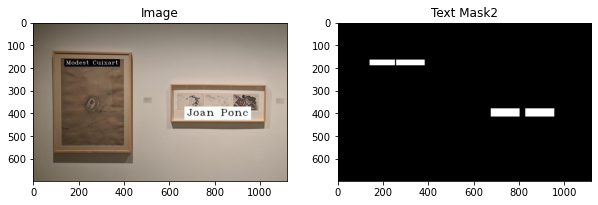

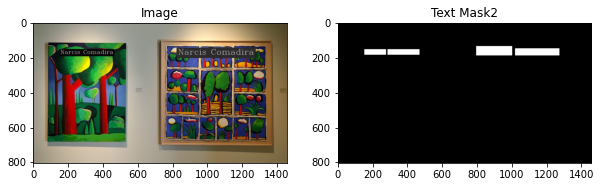

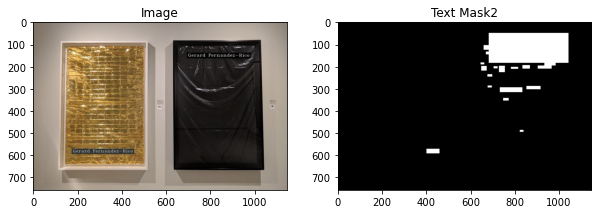

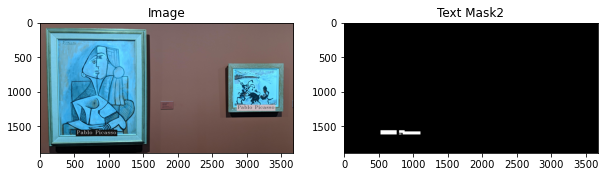

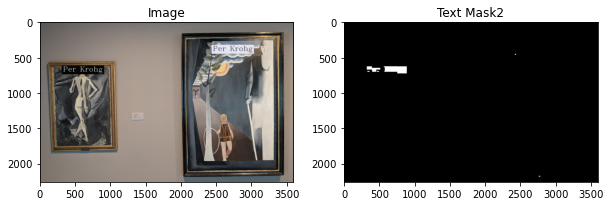

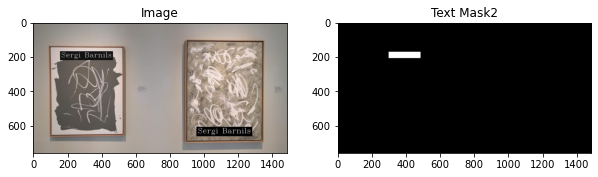

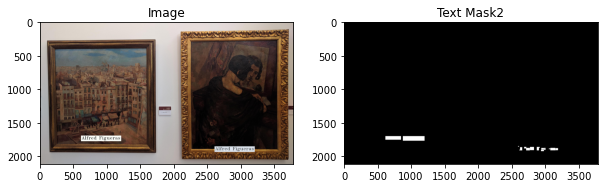

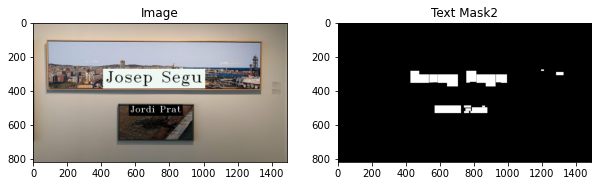

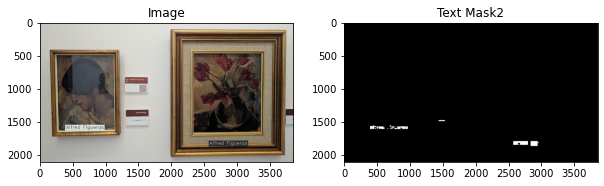

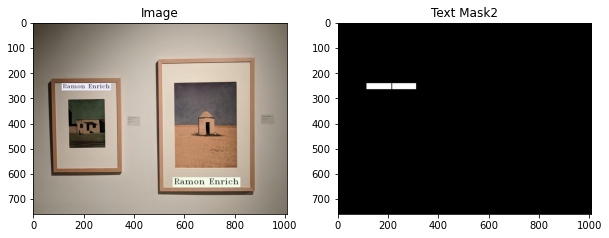

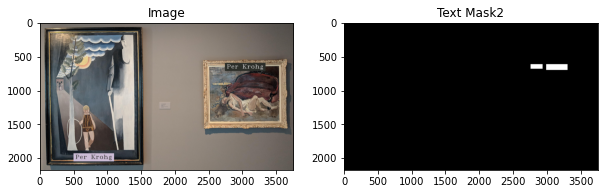

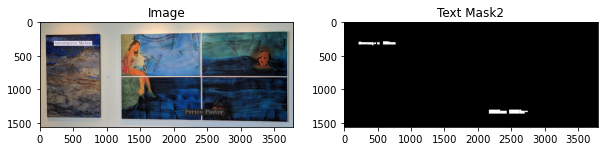

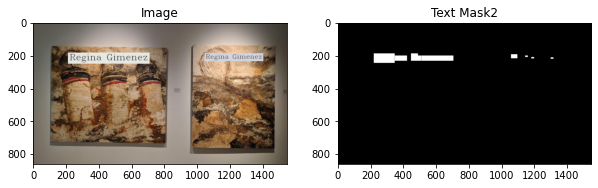

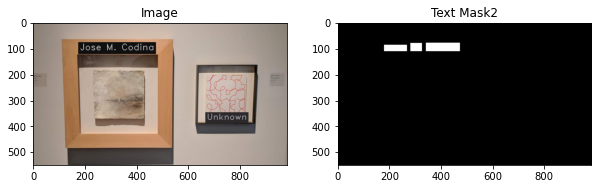

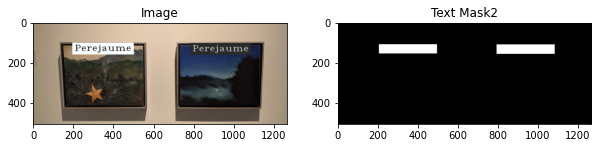

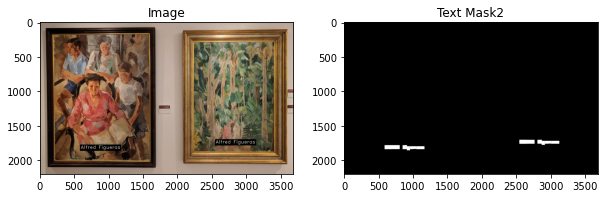

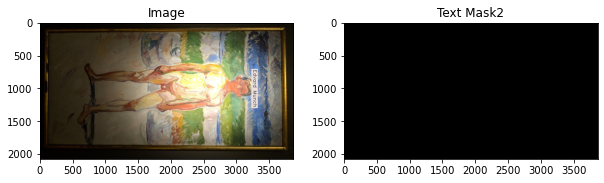

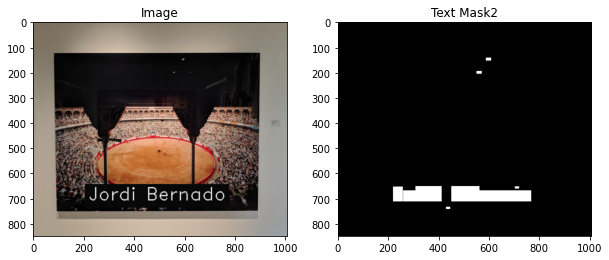

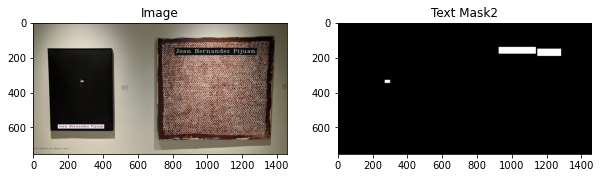

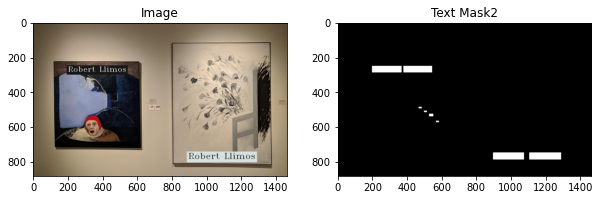

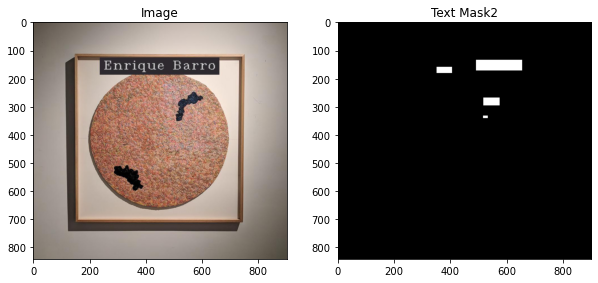

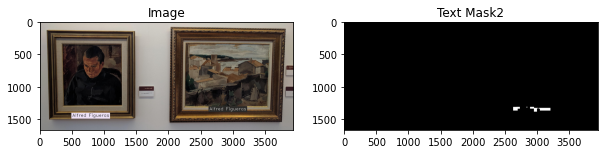

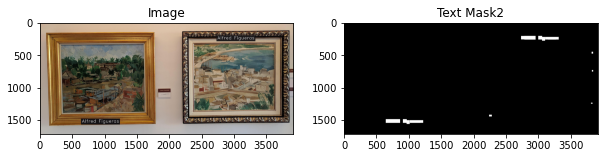

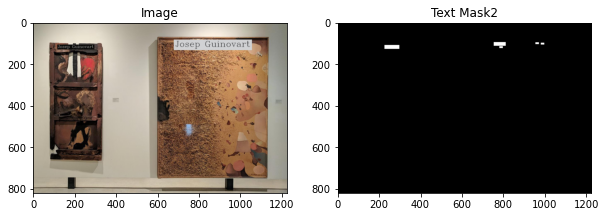

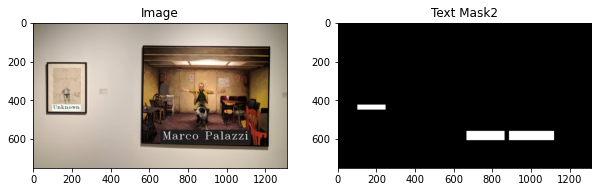

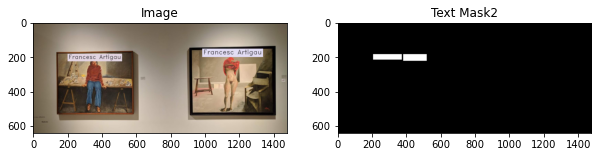

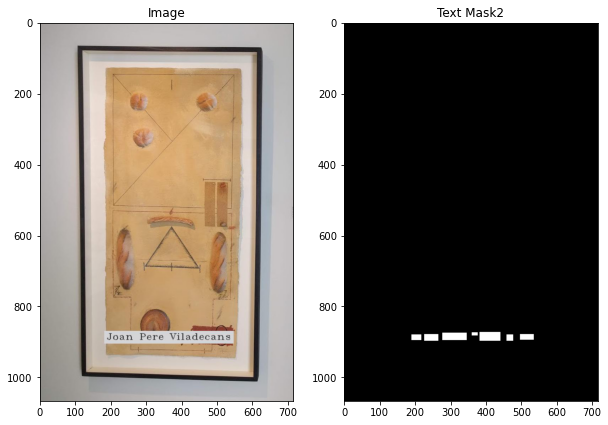

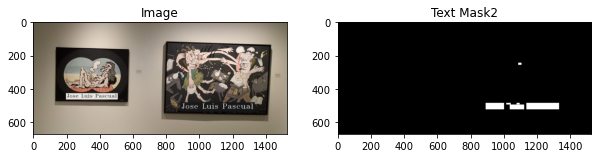

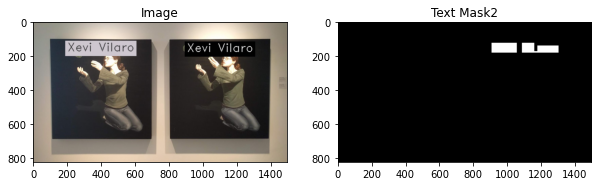

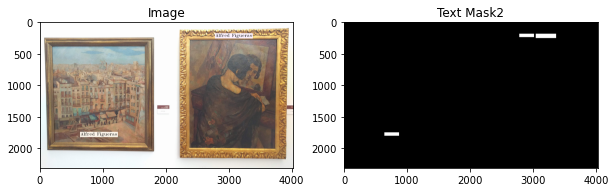

In [190]:
#39/50
for image in qsd2_w2:
    find_text(image)